# Bayesian Optimization: Searching for the global minima
**You should hand in a report, via Canvas, maximum 6 pages (excluding references). 
Do not attach any appendices. In the report you should present your data, models and the final results.
Do not forget to visualize your data and results.
It is important that you discuss your findings and reflect on the results.
In addition you need to hand in your Python code.
The code itself will not be graded, but it should run without errors and upon inspection reproduce the main results you present in the report.
Emphasis will be put on your ability to use appropriate terminology to describe and discuss the employed statistical methodologies and results.**

**<font color=red>DEADLINE: Dec 10 (Tuesday), 23:59</font>**

## Background
In this project you will explore and search the potential energy surface (PES) for an Au atom placed on top of a Au surface.
We will use a gold surface with Miller indices (433), which is so-called vicinal surface, corresponding to stepped (111) surface.
The Au atom  placed ontop of the surface is refered to as an ad-atom.

<img src="images/surface_433.png" alt="Drawing" style="width: 850px;"/>

Here the left image shows a side view of the surface with the ad-atom colored in red.
The right image shows the top view ($z$-direction) of the surface with the primitive cell marked as the smaller rectangle drawn in black.

Finding the position of the ad-atom with the lowest energy is a difficult problem as there are multiple local minima in the PES.
Furthermore, evaluating the potential energy is commonly done with density functional theory (DFT) which is very computationally expensive and hence it is desirable to keep the number of potential energy calculations as low as possible.
To tackle these two problems we will employ Bayesian optimization using Gaussian Processes.

Additional information on a very similar task can be found in the [paper by Todorovic *et al.*](https://doi.org/10.1038/s41524-019-0175-2), a copy of which (`Todorovic-2019.pdf` is included in this directory).

## Atomstic structure
Here, instead of DFT, we will use an embedded medium theory calculator which is provided in [`ase`](https://wiki.fysik.dtu.dk/ase/index.html) or [`asap`](https://wiki.fysik.dtu.dk/asap).
You are given a atomistic surface in `structures/surface_supercell.xyz`, which can be read as
``` python
from ase.io import read
surface = read('structures/surface_supercell.xyz')
```
When searching for the optimal location of the ad-atom we only need to consider positions inside the primitive cell since the PES will be repeating itself if we move outside the primitive cell.
We therefore only consider position in the domain
\begin{equation}
0 < x < 16.65653 \quad  \land \quad 0 < y < 2.884996
\end{equation}


## Evaluating the PES
The ad-atom energy of interest, $E$, is defined as by
\begin{equation}
E = E_\text{ad} - E_\text{surface},
\end{equation}
where $E_\text{ad}$ is the potential energy of the system with the ad-atom present and $E_\text{surface}$ the energy of just the bare surface system.
When evaluating the PES, we consider the surface to be completly rigid and only allow the ad-atom to move.
The energy can thus be written as 
\begin{equation}
E = E(x,y,z),
\end{equation}
where $(x,y,z)$ corresponds to the position of the ad-atom.
Here, we will allow the $z$-coordinate of the ad-atom to relax to its local minima (given $x$ and $y$) and thus only consider the $x-y$ dependency of the energy, meaning we write the energy $E$ as
\begin{equation}
E(x, y) = \min_z E(x, y, z).
\end{equation}
The primary goal of this project is to find the global minimum of the function $E(x, y)$ in as few evaluations of $E(x, y)$ as possible.


## Bayesian Optimization
To this end, we turn to Bayesian optimization using Gaussian processes (GPs).
The idea is to iteratively train a GP to model the energy, $E(x, y)$, and use it to suggest new possible samples.

Let $\mathbf{X}$ be an array of shape $(N, 2)$ containing $(x, y)$ points as rows and $\boldsymbol{E}$ an array of length $N$ with energies corresponding to $E(x,y)$ for each point in $\mathbf{X}$.
First we construct an initial model from a few randomly drawn samples $\mathbf{X}$ and their corresponding energies $\boldsymbol{E}$.       
This allows us to train a GP for the given $\mathbf{X}$ and $\boldsymbol{E}$, which provides both an average value $\mu$ and a standard deviation $\sigma$ for the energy at $(x, y)$.

The next step is to select a new point $(x_\text{new},y_\text{new})$ for sampling.
This is done by finding the point $(x_\text{new},y_\text{new})$ in the domain that maximizes the so-called acquisition function $A(x, y)$.
In this project, we recommend using the lower confidence  bound (LCB) acquisition function, which is defined as 
\begin{equation}
A(x, y) = -\mu (x, y) + \beta \sigma (x,y).
\end{equation}
Here, $\beta$ is a hyperparameter that can be chosen approximately from the range 1 to 5.
A large value of $\beta$ will favor more exploration whereas a smaller value will lead to more exploitation.
* **Exploitation:** Search regions with low mean (low energy)
* **Exploration:** Search regions with high uncertainty/variance
You can also adaptively adjust $\beta$ during the Bayesian optimization.
Can you think of suitable protocols?

A new data point can thus be selected by
\begin{equation}
(x_\text{new}, y_\text{new}) = \arg \max_{x, y} A(x, y)
\end{equation}
Next the energy at this new point, $E(x_\text{new}, y_\text{new})$, is evaluated and added to our samples $\mathbf{X}$ and $\boldsymbol{E}$.
This allows a new GP model to be trained and we can iterate through this procedure until convergence is (hopefully) reached.


## GPy optimization
Setting up your GP model can be achieved using a snippet such as the following
```python
k1 = GPy.kern.RBF(input_dim=2)
k2 = GPy.kern.Bias(input_dim=2)
kernel = k1 + k2
model = GPy.models.GPRegression(x_data, y_data, kernel)
model.optimize()
print(model)
```
Where `model.optimize` will find the variance, length scale and bias that maximizes the log-likelihood for the GP.
The log-likelihood may be very flat or contain multiple local minima.
In case you end up with strange parameters (such as the lengthscale being $10^{-10}$ or $10^{10}$), it can help to rerun the optimization a few times which can automatically be done via
``` python
model.optimize_restarts()
```
Additionaly, it might help to put some reasonable constraints on the parameters, via
```python
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].constrain_bounded(0.1, 5)
```
Instead of strict constraints, one can also set priors over the parameters via, e.g.,
``` python
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
```

## Helper function for z-relaxation
Below is a helper function that you can use to carry out the relaxation over $z$.
It might be helpful to also define a function only taking $(x, y)$ as argument and setting $z$ to, e.g.,
```python
z = surface.positions[:, 2].max() + 3
```
to make sure the ad-atom sits on top of the surface, and then pass $(x,y,z)$ into `calculate_adatom_energy`.

In [7]:
from ase.constraints import FixAtoms, FixedLine
from ase.optimize import BFGS
from ase import Atom
import asap3
# from ase.calculators.emt import EMT


def calculate_adatom_energy(surface, position):
    """Adds adatom to the input surface configuration at the given position
    and relaxes the ad-atoms z-cooridnate.

    Parameters
    ----------
    bare_surface
        surface configuration without adatom
    position
        position (x, y, z) at which to insert adatom in Ångström

    Returns
    -------
    tuple comprising the energy of the adatom configuration
    """
    # add adatom
    surface_with_adatom = surface.copy()
    surface_with_adatom.append(Atom('Au', position))

    # attach calculator
    calc = asap3.EMT()
    surface_with_adatom.calc = calc

    # apply constraints
    constraints = []
    c = FixAtoms(indices=list(range(len(surface_with_adatom) - 1)))
    constraints.append(c)
    c = FixedLine(-1, [0, 0, 1])
    constraints.append(c)

    # relax configuration
    surface_with_adatom.set_constraint(constraints)
    dyn = BFGS(surface_with_adatom, logfile=None)
    dyn.run(fmax=0.02, steps=200)

    energy = surface_with_adatom.get_potential_energy()
    return energy

## Setup
In this project you will need [`ase`](https://wiki.fysik.dtu.dk/ase/index.html), [`asap`](https://wiki.fysik.dtu.dk/asap) and [`GPy`](https://sheffieldml.github.io/GPy/).

In [ ]:
import ase
import asap3
import GPy

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import ase
from ase.io import read
from tqdm.auto import trange, tqdm

# -------------------------
# Read bare surface
# -------------------------
surface = read('structures/surface_supercell.xyz')

# Domain limits for (x, y) in Å
DOMAIN_X = (0.0, 16.65653)
DOMAIN_Y = (0.0, 2.884996)

EPS_X = 1e-6
EPS_Y = 1e-6

# -------------------------
# Baseline surface energy
# -------------------------
bare_surface = surface.copy()
bare_surface.calc = asap3.EMT()
E_surface = bare_surface.get_potential_energy()
print(f"Baseline surface energy E_surface = {E_surface:.6f} eV")


# -------------------------
# Energy function E(x, y)
# -------------------------
def energy_xy(x, y, surface=surface, E_surface=E_surface, z_offset=3.0):
    """
    Adatom energy E(x, y) = min_z E(x, y, z) - E_surface.

    Uses the provided helper `calculate_adatom_energy` to relax z.
    """
    # ensure we are inside the domain (useful later for optimizers)
    if not (DOMAIN_X[0] <= x <= DOMAIN_X[1] and DOMAIN_Y[0] <= y <= DOMAIN_Y[1]):
        raise ValueError(f"(x,y)=({x:.3f},{y:.3f}) is outside the domain.")

    z0 = surface.positions[:, 2].max() + z_offset
    E_tot = calculate_adatom_energy(surface, (x, y, z0))
    return E_tot - E_surface  # adatom energy

Baseline surface energy E_surface = 6.872846 eV


## Task 1: Analyzing the PES (1.5p)
The first task of the project will be to generate and visualize the full PES, $E(x, y)$, on a grid for $(x,y)$.
This will give you access to the global minima by visual inspection and will help with understanding, e.g.,  how the optimization algorithms are working or whether they get stuck in the wrong minimum.

This task may take a few minute to run as it requires a lot of evaluations of the PES.

**Tasks:**
* Compute the PES, $E(x, y)$, on a dense grid for $x$ and $y$.
* Visualize the 2D PES as a heatmap.

In [15]:
# -------------------------
# Task 1: Compute PES on a grid
# -------------------------

# Grid resolution (tune if too slow/fast)
SIZE = 50  # number of points in x and y

x_grid = np.linspace(DOMAIN_X[0] + EPS_X, DOMAIN_X[1] - EPS_X, SIZE)
y_grid = np.linspace(DOMAIN_Y[0] + EPS_Y, DOMAIN_Y[1] - EPS_Y, SIZE)
X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')
E_grid = np.zeros_like(X)

for i in range(SIZE):
    for j in range(SIZE):
        E_grid[i, j] = energy_xy(X[i, j], Y[i, j])

# Find grid minimum (useful reference for later tasks)
min_idx = np.argmin(E_grid)
min_i, min_j = np.unravel_index(min_idx, E_grid.shape)
x_min, y_min = X[min_i, min_j], Y[min_i, min_j]
E_min = E_grid[min_i, min_j]

print(f"Grid minimum: E_min = {E_min:.6f} eV at (x, y) = ({x_min:.4f}, {y_min:.4f})")


Grid minimum: E_min = 0.221625 eV at (x, y) = (3.3993, 0.7065)


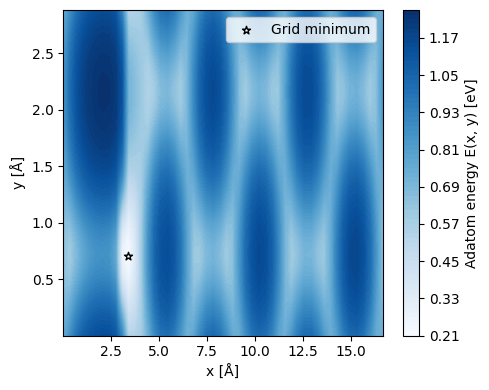

In [20]:
# Visualize PES as heatmap
fig, ax = plt.subplots(figsize=(5, 4))

plt.contourf(X, Y, E_grid, levels=100, cmap='Blues')
plt.colorbar(label='Adatom energy E(x, y) [eV]')

ax.set_xlabel('x [Å]')
ax.set_ylabel('y [Å]')

# Mark the (grid) global minimum
ax.scatter([x_min], [y_min], marker='*',
           edgecolor='k', facecolor='white', label='Grid minimum')
ax.legend()

plt.tight_layout()

In [21]:
from scipy.optimize import minimize

# Local search using scipy.optimize.minimize with bound constraints
def local_search_from_start(x0, y0):
    """
    Run a local minimization of E(x, y) starting from (x0, y0).

    Returns
    -------
    res : OptimizeResult
        Result object from scipy.optimize.minimize
    """
    def objective(x_vec):
        return energy_xy(x_vec[0], x_vec[1])

    bounds = [
        (DOMAIN_X[0] + EPS_X, DOMAIN_X[1] - EPS_X),
        (DOMAIN_Y[0] + EPS_Y, DOMAIN_Y[1] - EPS_Y),
    ]

    res = minimize(
        objective,
        x0=np.array([x0, y0]),
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 200}
    )
    return res


# Number of random local searches
n_starts = 20
rng = np.random.default_rng(123)

# Uniform random starting points over the (x, y) domain
start_points = np.column_stack([
    rng.uniform(DOMAIN_X[0] + EPS_X, DOMAIN_X[1] - EPS_X, size=n_starts),
    rng.uniform(DOMAIN_Y[0] + EPS_Y, DOMAIN_Y[1] - EPS_Y, size=n_starts),
])

# Run local searches and store final minima
min_positions = np.zeros((n_starts, 2))
min_energies = np.zeros(n_starts)
success_flags = np.zeros(n_starts, dtype=bool)

for k in range(n_starts):
    x0, y0 = start_points[k]
    res = local_search_from_start(x0, y0)
    min_positions[k, :] = res.x
    min_energies[k] = res.fun
    success_flags[k] = res.success

# Define what "ending up in the global minimum" means
pos_tol = 0.15   # Å tolerance in position
E_tol = 1e-3     # eV tolerance in energy

dist_to_global = np.sqrt(
    (min_positions[:, 0] - x_min) ** 2 +
    (min_positions[:, 1] - y_min) ** 2
)

is_global = (
    (dist_to_global < pos_tol) &
    (np.abs(min_energies - E_min) < E_tol) &
    success_flags
)

n_success = np.sum(success_flags)
n_global = np.sum(is_global)

print(f"Total local searches: {n_starts}")
print(f"Successful optimizations: {n_success}")
print(f"Converged to global minimum (within tolerances): {n_global}")
print(f"Fraction of all runs ending in global minimum: {n_global / n_starts:.3f}")
print(f"Fraction of successful runs ending in global minimum: {n_global / max(n_success, 1):.3f}")

Total local searches: 20
Successful optimizations: 20
Converged to global minimum (within tolerances): 0
Fraction of all runs ending in global minimum: 0.000
Fraction of successful runs ending in global minimum: 0.000


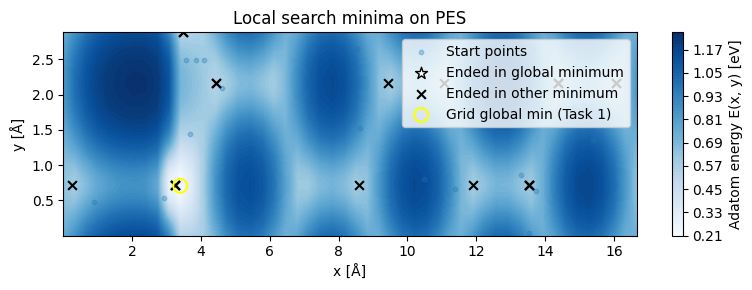

In [22]:
# Visualize where the local minima ended up on top of the PES
fig, ax = plt.subplots(figsize=(8, 3))

plt.contourf(X, Y, E_grid, levels=100, cmap='Blues')
plt.colorbar(label='Adatom energy E(x, y) [eV]')
ax.set_xlabel('x [Å]')
ax.set_ylabel('y [Å]')
ax.set_title('Local search minima on PES')

# Starting points
ax.scatter(start_points[:, 0], start_points[:, 1],
           s=10, alpha=0.3, label='Start points')

# Minima classified as global
ax.scatter(min_positions[is_global, 0], min_positions[is_global, 1],
           marker='*', s=80, edgecolor='k', facecolor='white',
           label='Ended in global minimum')

# Minima classified as other local minima
ax.scatter(min_positions[~is_global, 0], min_positions[~is_global, 1],
           marker='x', s=40, color='black', label='Ended in other minimum')

# Mark the grid-based global minimum from Task 1
ax.scatter([x_min], [y_min], marker='o', s=100,
           edgecolor='yellow', facecolor='none', linewidth=1.5,
           label='Grid global min (Task 1)')

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Task 2: Local search (3p)

In this task you will try out local search (gradient descent) and see how it succeeds or fails for our function $E(x,y)$.

For the local search consider a random starting position uniformly drawn from the $\{x,y\}$ domain.

**Tasks:**
* From visual inspection of the PES in Task 1, can you obtain a rough estimate for the percentage of local searches that would end up in the global minimum.
* Run a few (50-500) local searches and record how many ended up in the global minimum.

*Hint:* `scipy.optimize.minimize` can be used

## Task 3: Bayesian optimization (7p)
Implement your own Bayesian optimization algorithm (using GPy for the Gaussian process part) and run it to find the global minima of $E(x, y)$.

Use the [RBF kernel](https://gpy.readthedocs.io/en/deploy/GPy.kern.src.html#module-GPy.kern.src.rbf) and include a Bias kernel if it is needed.

Suitable $\beta$ values might be in the range 1 to 5.

Start the Bayesian optimization from five (5) randomly drawn samples.        


**Tasks:**
* Given the PES in Task 1 choose and motivate priors for the lengthscale and variance parameters in the RBF kernel.
* Run Bayesian optimization and analyze how the choice of $\beta$ influences convergence. Select a good value for $\beta$.
* Rerun bayesian optimization with the selected $\beta$. How many iterations are needed until the global minimum is reached?
* Visualize the PES, the uncertainty ($\sigma$) and the acquisition function together with your samples for the final model.
* In what regions is the final GP model the most uncertain? Why?


*Hints:*
* If your algorithm gets stuck sampling the same points over and over again, try increasing $\beta$ (more exploration).         
* To find the argmax of $A(x, y)$ you can either evaluate it on a very dense grid or run multiple local searches (starting from random positions) and take the maximum obtained.

In [35]:
import GPy
# Helper: build and optimize GP model
def build_gp_model(X_train, y_train):
    """
    X_train: (N, 2)
    y_train: (N,) or (N, 1)
    Returns a trained GPy GPRegression model.
    """
    if y_train.ndim == 1:
        y_train = y_train[:, None]

    k_rbf = GPy.kern.RBF(input_dim=2, name="rbf")
    k_bias = GPy.kern.Bias(input_dim=2, name="bias")
    kernel = k_rbf + k_bias

    # # Simple, physically motivated constraints
    # # Lengthscale: not crazy small or huge compared to domain (~1–10 Å)
    # k_rbf.lengthscale.constrain_bounded(0.1, 5.0)
    # # Variance: avoid degenerate extremes
    # k_rbf.variance.constrain_bounded(1e-4, 1.0)

    # Optional: weak priors on lengthscale and variance
    k_rbf.lengthscale.set_prior(GPy.priors.Gamma(2.0, 1.0), warning=False)
    k_rbf.variance.set_prior(GPy.priors.Gamma(2.0, 1.0), warning=False)

    model = GPy.models.GPRegression(X_train, y_train, kernel)
    # model.Gaussian_noise.variance.constrain_bounded(1e-6, 1e-2)

    # Hyperparameter optimization; restarts help escape bad local optima
    model.optimize_restarts(num_restarts=5, verbose=False)
    return model


# Helper: LCB acquisition function
def compute_lcb_acquisition(model, X_test, beta):
    """
    X_test: (M, 2)
    Returns A, mu, sigma all with shape (M, 1).
    """
    mu, var = model.predict(X_test)
    sigma = np.sqrt(var)
    A = -mu + beta * sigma
    return A, mu, sigma


# Helper: pick next point by maximizing acquisition on a grid, avoiding duplicates
def select_next_point_from_grid(model, beta, X_grid_flat, X_seen, dist_tol=1e-3):
    """
    X_grid_flat: (M, 2) grid of candidate points
    X_seen: (N, 2) points already sampled
    Returns next_x, next_y.
    """
    A_flat, _, _ = compute_lcb_acquisition(model, X_grid_flat, beta)
    A_flat = A_flat.ravel()

    # Mask out points that are too close to already sampled locations
    if X_seen is not None and len(X_seen) > 0:
        for i, x_test in enumerate(X_grid_flat):
            if np.min(np.linalg.norm(X_seen - x_test, axis=1)) < dist_tol:
                A_flat[i] = -np.inf

    if np.all(~np.isfinite(A_flat)):
        raise RuntimeError("All candidate points are masked or acquisition is -inf everywhere.")

    idx_best = np.argmax(A_flat)
    x_best, y_best = X_grid_flat[idx_best]
    return x_best, y_best, A_flat.reshape(X.shape)


# Main Bayesian optimization loop
def bayesian_optimization(beta, n_init=5, n_iter=40, rng=None):
    """
    Runs Bayesian optimization with LCB acquisition.

    beta: exploration parameter
    n_init: number of initial random samples
    n_iter: number of BO iterations (new samples)
    rng: np.random.Generator or None

    Returns
    -------
    X_samples: (n_init + n_iter, 2) sampled points
    y_samples: (n_init + n_iter,) energies
    best_y_per_iter: (n_init + n_iter,) best value found up to each step
    final_model: trained GPy model on all samples
    """
    if rng is None:
        rng = np.random.default_rng()

    # Initial random samples in the domain
    X_init = np.column_stack([
        rng.uniform(DOMAIN_X[0] + EPS_X, DOMAIN_X[1] - EPS_X, size=n_init),
        rng.uniform(DOMAIN_Y[0] + EPS_Y, DOMAIN_Y[1] - EPS_Y, size=n_init),
    ])
    y_init = np.array([energy_xy(x, y) for x, y in X_init])

    X_list = [X_init]
    y_list = [y_init]

    # Grid for acquisition search (reuse X, Y from Task 1)
    X_grid_flat = np.column_stack([X.ravel(), Y.ravel()])

    best_y_so_far = []
    X_all = X_init.copy()
    y_all = y_init.copy()

    for t in trange(n_iter):
        model = build_gp_model(X_all, y_all)

        x_next, y_next, _ = select_next_point_from_grid(
            model, beta, X_grid_flat, X_seen=X_all
        )
        y_next_val = energy_xy(x_next, y_next)

        X_all = np.vstack([X_all, [x_next, y_next]])
        y_all = np.concatenate([y_all, [y_next_val]])

        best_y_so_far.append(np.min(y_all))

        # print(f"[beta={beta:.2f}] Iteration {t+1}/{n_iter}: "
        #       f"new point ({x_next:.3f}, {y_next:.3f}), E = {y_next_val:.6f} eV, "
        #       f"best so far = {np.min(y_all):.6f} eV")

    best_y_per_iter = np.concatenate([
        np.minimum.accumulate(y_init),
        np.array(best_y_so_far)
    ])

    final_model = build_gp_model(X_all, y_all)

    return X_all, y_all, best_y_per_iter, final_model


Running Bayesian optimization with beta = 1.0


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]



Running Bayesian optimization with beta = 2.5


100%|██████████| 30/30 [00:22<00:00,  1.36it/s]



Running Bayesian optimization with beta = 5.0


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


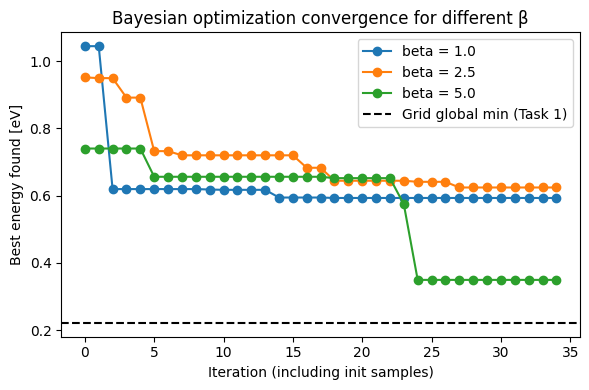

In [37]:
# Beta values to compare (exploration vs exploitation)
betas = [1.0, 2.5, 5.0]
n_init = 5
n_iter = 30

rng = np.random.default_rng(42)
bo_results = {}

for beta in betas:
    print(f"\nRunning Bayesian optimization with beta = {beta}")
    X_s, y_s, best_y, model = bayesian_optimization(
        beta=beta,
        n_init=n_init,
        n_iter=n_iter,
        rng=rng
    )
    bo_results[beta] = {
        "X": X_s,
        "y": y_s,
        "best_y": best_y,
        "model": model,
    }

# Plot convergence: best energy vs iteration for each beta
fig, ax = plt.subplots(figsize=(6, 4))

for beta in betas:
    best_y = bo_results[beta]["best_y"]
    it_axis = np.arange(len(best_y))
    ax.plot(it_axis, best_y, "-o", label=f"beta = {beta}")

ax.axhline(E_min, color="k", linestyle="--", label="Grid global min (Task 1)")
ax.set_xlabel("Iteration (including init samples)")
ax.set_ylabel("Best energy found [eV]")
ax.set_title("Bayesian optimization convergence for different β")
ax.legend()
plt.tight_layout()
plt.show()

100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


[beta = 2.0] Global minimum reached within 1.0e-03 eV at iteration 12.


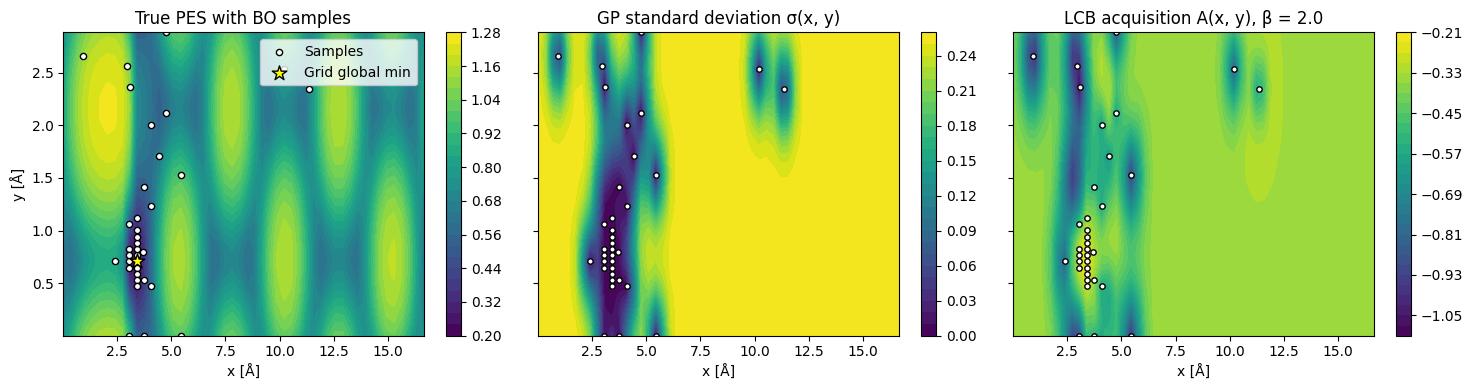

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_global_hit_from_curve(best_y_curve, beta, E_min, E_tol=1e-3):
    """
    Given a best-so-far energy curve from BO, report when the global minimum
    (from Task 1) is reached within E_tol.
    """
    diff = best_y_curve - E_min
    hit_idx = np.where(diff <= E_tol)[0]

    if len(hit_idx) > 0:
        iter_to_global = int(hit_idx[0])
        print(
            f"[beta = {beta}] Global minimum reached within {E_tol:.1e} eV "
            f"at iteration {iter_to_global}."
        )
    else:
        iter_to_global = None
        print(
            f"[beta = {beta}] Global minimum not reached within {E_tol:.1e} eV."
        )

    return iter_to_global


def gp_predict_on_grid(model, X, Y):
    """
    Predict GP mean and standard deviation on a grid defined by X, Y.
    Returns mu_grid, sigma_grid.
    """
    X_grid_flat = np.column_stack([X.ravel(), Y.ravel()])
    mu_flat, var_flat = model.predict(X_grid_flat)
    sigma_flat = np.sqrt(var_flat)

    mu_grid = mu_flat.reshape(X.shape)
    sigma_grid = sigma_flat.reshape(X.shape)
    return mu_grid, sigma_grid


def acquisition_on_grid(model, X, Y, beta):
    """
    Compute LCB acquisition A(x, y) on a grid defined by X, Y for a given beta.
    Returns A_grid.
    """
    X_grid_flat = np.column_stack([X.ravel(), Y.ravel()])
    A_flat, _, _ = compute_lcb_acquisition(model, X_grid_flat, beta)
    A_grid = A_flat.reshape(X.shape)
    return A_grid


def plot_bo_summary(E_grid, X, Y,
                    X_samples, x_min, y_min,
                    sigma_grid, A_grid, beta):
    """
    Plot:
      1) True PES with BO samples
      2) GP standard deviation sigma(x,y)
      3) LCB acquisition A(x,y)
    using contourf.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    # Panel 1: true PES with BO samples
    cs0 = axes[0].contourf(X, Y, E_grid, levels=30)
    fig.colorbar(cs0, ax=axes[0])
    axes[0].scatter(X_samples[:, 0], X_samples[:, 1],
                    s=20, c="white", edgecolor="k", label="Samples")
    axes[0].scatter([x_min], [y_min],
                    marker="*", s=120, edgecolor="k", facecolor="yellow",
                    label="Grid global min")
    axes[0].set_title("True PES with BO samples")
    axes[0].set_xlabel("x [Å]")
    axes[0].set_ylabel("y [Å]")
    axes[0].legend(loc="upper right")

    # Panel 2: GP standard deviation sigma(x,y)
    cs1 = axes[1].contourf(X, Y, sigma_grid, levels=30)
    fig.colorbar(cs1, ax=axes[1])
    axes[1].scatter(X_samples[:, 0], X_samples[:, 1],
                    s=15, c="white", edgecolor="k")
    axes[1].set_title("GP standard deviation σ(x, y)")
    axes[1].set_xlabel("x [Å]")

    # Panel 3: LCB acquisition A(x,y)
    cs2 = axes[2].contourf(X, Y, A_grid, levels=30)
    fig.colorbar(cs2, ax=axes[2])
    axes[2].scatter(X_samples[:, 0], X_samples[:, 1],
                    s=15, c="white", edgecolor="k")
    axes[2].set_title(f"LCB acquisition A(x, y), β = {beta}")
    axes[2].set_xlabel("x [Å]")

    plt.tight_layout()
    plt.show()


def run_bo_experiment(beta,
                      n_init=5,
                      n_iter=30,
                      rng_seed=42,
                      E_min=E_min,
                      E_tol=1e-3):
    """
    Run a full BO experiment for a given beta and hyperparameters:
      - run Bayesian optimization
      - report when global minimum is reached
      - compute GP uncertainty and acquisition on grid
      - plot summary (PES+samples, sigma, acquisition)

    Parameters
    ----------
    beta : float
        LCB exploration parameter.
    n_init : int
        Number of initial random samples.
    n_iter : int
        Number of BO iterations (new points).
    rng_seed : int
        Seed for RNG (reproducibility).
    E_min : float
        Global minimum energy from the full PES grid (Task 1).
    E_tol : float
        Tolerance for considering the global minimum "found".
    """
    rng = np.random.default_rng(rng_seed)

    X_samples, y_samples, best_y_curve, model = bayesian_optimization(
        beta=beta,
        n_init=n_init,
        n_iter=n_iter,
        rng=rng
    )

    iter_to_global = analyze_global_hit_from_curve(
        best_y_curve, beta=beta, E_min=E_min, E_tol=E_tol
    )

    mu_grid, sigma_grid = gp_predict_on_grid(model, X, Y)
    A_grid = acquisition_on_grid(model, X, Y, beta)

    plot_bo_summary(
        E_grid=E_grid,
        X=X,
        Y=Y,
        X_samples=X_samples,
        x_min=x_min,
        y_min=y_min,
        sigma_grid=sigma_grid,
        A_grid=A_grid,
        beta=beta,
    )

    return {
        "beta": beta,
        "n_init": n_init,
        "n_iter": n_iter,
        "rng_seed": rng_seed,
        "X_samples": X_samples,
        "y_samples": y_samples,
        "best_y_curve": best_y_curve,
        "model": model,
        "iter_to_global": iter_to_global,
    }


# Example usage:
# You can change beta, n_init, n_iter, rng_seed as you like.
result_beta_3 = run_bo_experiment(
    beta=2.0,
    n_init=5,
    n_iter=30,
    rng_seed=123,
    E_min=E_min,
    E_tol=1e-3,
)

## Task 4: Transition paths barriers (4.5p)
In Bayesian optimization the low energy regions of the parameter space $(x, y)$ are of interest and thus get sampled more by the acquisition function.    
Next we look at using GPs as a general purpose potential/model for the full PES.
In principle once one has a fast and accurate model over the entire PES we could compute various properties of the ad-atom, such as diffusion barriers and thermodynamic properties.

Here you will look at the energy landscape along a linear path between the global minima and the local energy minimum around $(11, 2.1)$.
To construct the linear path from the initial state to the final state we can write
\begin{equation}
(x, y) = (x_{start}, y_{start}) + \lambda ( x_{end} -x_{start}, y_{end}-y_{start})
\end{equation}
where $\lambda$ should be varied between $0 \to 1$ to span the path.

In this task you will construct a general purpose GP to model the PES and compute the energy along the transition path described above.
This may require 100 to 200 or more training samples.
Use $(x_\text{start}, y_\text{start})$ and $(x_\text{end}, y_\text{end})$ plus a few random samples as a starting point and then iterativley construct a GP model using a suitable acquisition function.

**Tasks:**
* Train a general purpose GP model.
* Compute the error (e.g., [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) of the model evaluated over the entire PES using data from Task 1 as a function of training samples. How many samples are needed to get a "good" model in your opinion?
* Use the GP model to compute the energy and its uncertainty along the linear path between the initial and final state. Compare with the GP model obtained in Task 3, and compare with the correct energy along the path computed with EMT. Discuss your findings.


*Hint:* To train a general purpose model one can use the LCB acquisition function and let $\beta \to \infty$.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Find the local minimum near (11, 2.1) using the Task 2 local search
start_guess = np.array([11.0, 2.1])
res_local = local_search_from_start(start_guess[0], start_guess[1])
x_local, y_local = res_local.x
E_local = res_local.fun

print(f"Local minimum near (11, 2.1): E = {E_local:.6f} eV at (x, y) = ({x_local:.4f}, {y_local:.4f})")

# Global minimum from Task 1 is (x_min, y_min)
x_start, y_start = x_min, y_min           # global minimum
x_end, y_end = x_local, y_local           # local minimum around (11, 2.1)


def general_purpose_bo(beta_explore,
                       x_start, y_start,
                       x_end, y_end,
                       n_init_random=5,
                       n_iter=150,
                       rng_seed=123):
    """
    General-purpose sampling of the PES using an exploration-heavy BO.

    Initial points:
      - global minimum (x_start, y_start)
      - local minimum (x_end, y_end)
      - n_init_random random points

    Then we iteratively pick new samples by maximizing LCB with a large beta_explore.
    """
    rng = np.random.default_rng(rng_seed)

    X_init_random = np.column_stack([
        rng.uniform(DOMAIN_X[0] + EPS_X, DOMAIN_X[1] - EPS_X, size=n_init_random),
        rng.uniform(DOMAIN_Y[0] + EPS_Y, DOMAIN_Y[1] - EPS_Y, size=n_init_random),
    ])

    X_init = np.vstack([
        [x_start, y_start],
        [x_end, y_end],
        X_init_random
    ])

    y_init = np.array([energy_xy(x, y) for x, y in X_init])

    X_all = X_init.copy()
    y_all = y_init.copy()

    X_grid_flat = np.column_stack([X.ravel(), Y.ravel()])

    for t in trange(n_iter):
        model = build_gp_model(X_all, y_all)
        x_next, y_next, _ = select_next_point_from_grid(
            model,
            beta=beta_explore,
            X_grid_flat=X_grid_flat,
            X_seen=X_all
        )
        y_next_val = energy_xy(x_next, y_next)

        X_all = np.vstack([X_all, [x_next, y_next]])
        y_all = np.concatenate([y_all, [y_next_val]])


    final_model = build_gp_model(X_all, y_all)
    return X_all, y_all, final_model


def gp_predict_on_grid(model, X, Y):
    """
    Predict GP mean and standard deviation on a grid defined by X, Y.
    """
    X_grid_flat = np.column_stack([X.ravel(), Y.ravel()])
    mu_flat, var_flat = model.predict(X_grid_flat)
    sigma_flat = np.sqrt(var_flat)

    mu_grid = mu_flat.reshape(X.shape)
    sigma_grid = sigma_flat.reshape(X.shape)
    return mu_grid, sigma_grid


def compute_rmse_vs_n_samples(X_all, y_all, E_grid, X, Y, n_values):
    """
    For a sequence of training set sizes n_values, train a GP on the first n points
    and compute RMSE over the full PES grid.
    """
    rmse_list = []

    for n in n_values:
        X_train = X_all[:n]
        y_train = y_all[:n]
        model_n = build_gp_model(X_train, y_train)
        mu_grid, _ = gp_predict_on_grid(model_n, X, Y)

        diff = mu_grid - E_grid
        rmse = np.sqrt(np.mean(diff**2))
        rmse_list.append(rmse)

        print(f"RMSE with {n} samples: {rmse:.6f} eV")

    return np.array(rmse_list)


def make_transition_path(x_start, y_start, x_end, y_end, n_points=100):
    """
    Construct a linear path between (x_start, y_start) and (x_end, y_end).
    Returns lambda values, path coordinates, and true EMT energies along the path.
    """
    lam = np.linspace(0.0, 1.0, n_points)
    x_path = x_start + lam * (x_end - x_start)
    y_path = y_start + lam * (y_end - y_start)

    E_true = np.array([energy_xy(x, y) for x, y in zip(x_path, y_path)])
    return lam, x_path, y_path, E_true


def evaluate_path_with_model(model, x_path, y_path):
    """
    Evaluate a GP model along a given path.
    Returns mean and std arrays for each point along the path.
    """
    X_path = np.column_stack([x_path, y_path])
    mu, var = model.predict(X_path)
    sigma = np.sqrt(var)
    mu = mu.ravel()
    sigma = sigma.ravel()
    return mu, sigma


def plot_transition_path(lam,
                         E_true,
                         mu_task3, sigma_task3,
                         mu_general, sigma_general,
                         label_task3="Task 3 GP",
                         label_general="General GP"):
    """
    Plot the energy along the path for:
      - true EMT energies
      - Task 3 GP model
      - general-purpose GP model
    with uncertainty bands for the two GPs.
    """
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.plot(lam, E_true, "-k", label="True EMT")

    ax.plot(lam, mu_task3, "-", label=label_task3)
    ax.fill_between(lam, mu_task3 - 2 * sigma_task3, mu_task3 + 2 * sigma_task3,
                    alpha=0.2)

    ax.plot(lam, mu_general, "-", label=label_general)
    ax.fill_between(lam, mu_general - 2 * sigma_general, mu_general + 2 * sigma_general,
                    alpha=0.2)

    ax.set_xlabel("λ along path (0 = global min, 1 = local min)")
    ax.set_ylabel("Energy [eV]")
    ax.set_title("Energy profile along transition path")
    ax.legend()
    plt.tight_layout()
    plt.show()

Local minimum near (11, 2.1): E = 0.594552 eV at (x, y) = (11.0692, 2.1637)


 60%|█████▉    | 119/200 [02:46<02:37,  1.94s/it] /Users/noord/Library/CloudStorage/OneDrive-Chalmers/Master2/Avancerad simulering och maskininlärning TIF345/tif345-env/lib/python3.12/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /Users/noord/Library/CloudStorage/OneDrive-Chalmers/Master2/Avancerad simulering och maskininlärning TIF345/tif345-env/lib/python3.12/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply
100%|██████████| 200/200 [04:43<00:00,  1.42s/it]


RMSE with 10 samples: 0.249067 eV
RMSE with 32 samples: 0.140432 eV
RMSE with 54 samples: 0.090826 eV
RMSE with 76 samples: 0.056437 eV
RMSE with 98 samples: 0.046922 eV
RMSE with 121 samples: 0.042848 eV
RMSE with 143 samples: 0.033314 eV
RMSE with 165 samples: 0.029126 eV
RMSE with 187 samples: 0.025447 eV
RMSE with 210 samples: 0.021224 eV


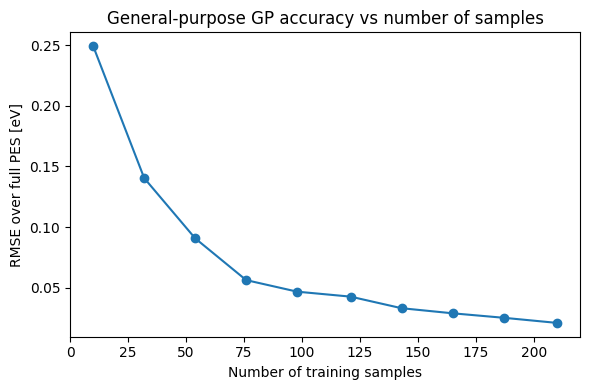

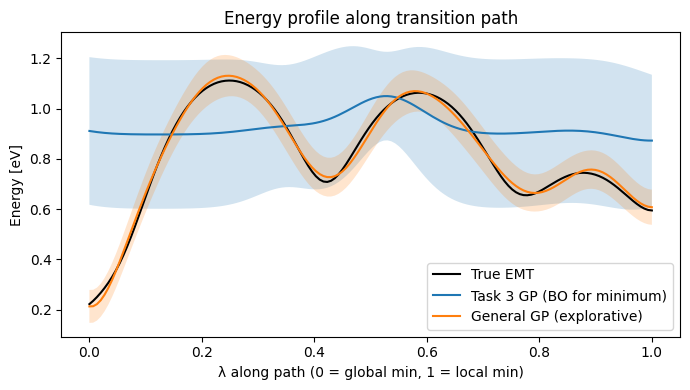

In [46]:
# Choose the Task 3 GP model to compare with
# Example if you used run_bo_experiment earlier:
# model_task3 = result_beta_3["model"]
# or from your bo_results dict: model_task3 = bo_results[beta_star]["model"]
model_task3 = bo_results[2.5]["model"]  # adjust to your chosen beta


# Train a general-purpose GP with strong exploration
beta_explore = 50.0      # "beta → ∞" in practice: very exploration-heavy
n_init_random = 8
n_iter_general = 200

X_gen, y_gen, model_general = general_purpose_bo(
    beta_explore=beta_explore,
    x_start=x_start, y_start=y_start,
    x_end=x_end, y_end=y_end,
    n_init_random=n_init_random,
    n_iter=n_iter_general,
    rng_seed=202
)

# Compute RMSE vs number of samples
n_total = len(X_gen)
n_values = np.linspace(10, n_total, 10, dtype=int)  # 10 points from 10 to full set

rmse_values = compute_rmse_vs_n_samples(
    X_all=X_gen,
    y_all=y_gen,
    E_grid=E_grid,
    X=X,
    Y=Y,
    n_values=n_values
)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(n_values, rmse_values, "-o")
ax.set_xlabel("Number of training samples")
ax.set_ylabel("RMSE over full PES [eV]")
ax.set_title("General-purpose GP accuracy vs number of samples")
plt.tight_layout()
plt.show()

# Decide from the plot how many samples you consider "good enough" in the report.


# Build the transition path and compare models along it
lam, x_path, y_path, E_true_path = make_transition_path(
    x_start=x_start,
    y_start=y_start,
    x_end=x_end,
    y_end=y_end,
    n_points=150
)

mu_task3_path, sigma_task3_path = evaluate_path_with_model(
    model_task3, x_path, y_path
)
mu_general_path, sigma_general_path = evaluate_path_with_model(
    model_general, x_path, y_path
)

plot_transition_path(
    lam=lam,
    E_true=E_true_path,
    mu_task3=mu_task3_path,
    sigma_task3=sigma_task3_path,
    mu_general=mu_general_path,
    sigma_general=sigma_general_path,
    label_task3="Task 3 GP (BO for minimum)",
    label_general="General GP (explorative)"
)